In [1]:
import os
import re
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
from dateutil.parser import parse

import itertools
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients

from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank

from functions import *

import warnings
warnings.filterwarnings('ignore')

C:\Users\zhang\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Read Data and Preprocessing

In [2]:
df = pd.read_csv('Australia Energy Demand.csv')
df_resample = fill_null_date(df, 'date')
df_filter = median_filter(df_resample, list(df_resample.columns), window=21, std=3, fill=True)
df_filter.head(5)

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall
date,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0


In [3]:
cols = ['demand', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']
df_final = df_filter[cols]
df_final['demand'] = df_final['demand']/1000
# df_final['max_temperature_1'] = np.log(abs(df_final['max_temperature'] - np.mean(df_final['max_temperature']))+10)
df_final['max_temperature_1'] = abs(df_final['max_temperature'] - np.mean(df_final['max_temperature']))
df_final.head(5)

,demand,min_temperature,max_temperature,solar_exposure,rainfall,max_temperature_1
date,,,,,,
2015-01-01,99.635030,13.3,26.9,23.6,0.0,6.501425
2015-01-02,129.606010,15.4,38.8,26.8,0.0,18.401425
2015-01-03,142.300540,20.0,38.2,26.5,0.0,17.801425
2015-01-04,104.330715,16.3,21.4,25.2,4.2,1.001425
2015-01-05,118.132200,15.0,22.0,30.7,0.0,1.601425


## A first glance at data

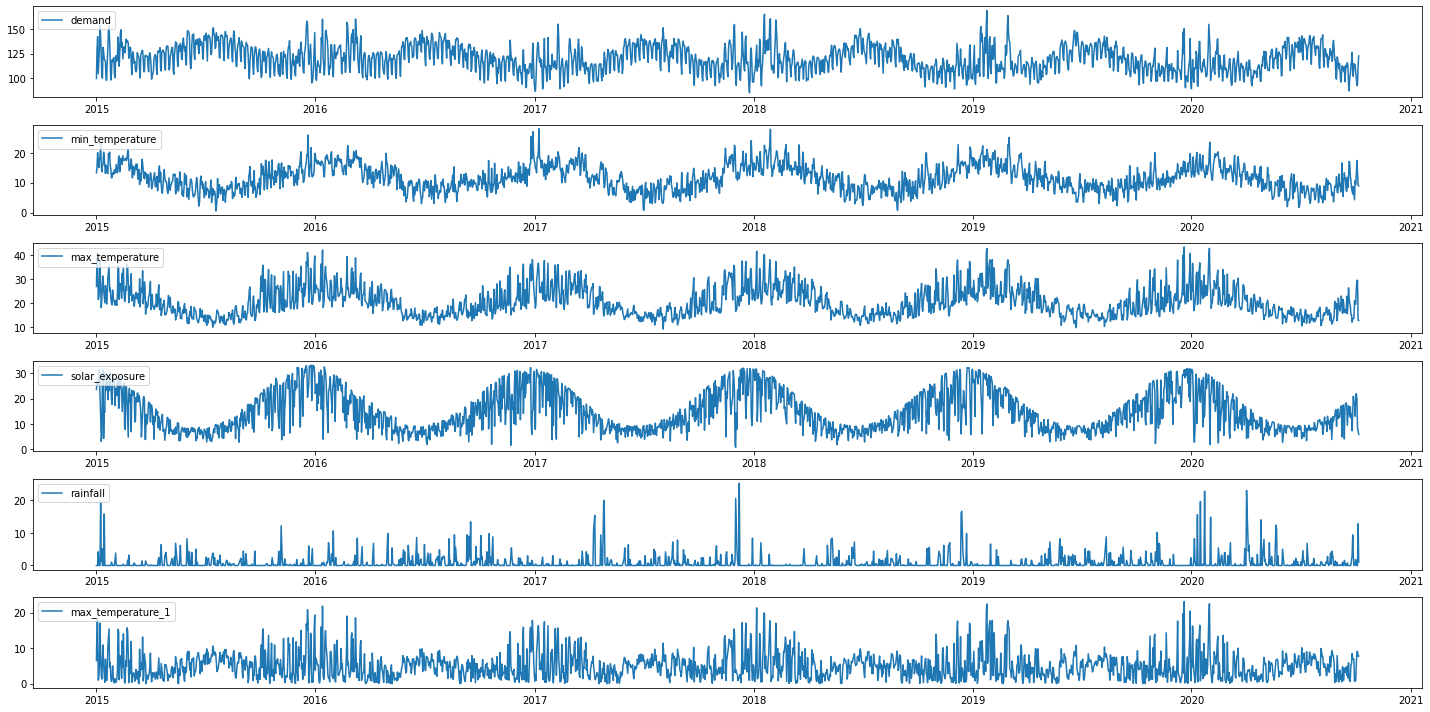

In [4]:
plt.figure(figsize=(20,10))
draw_line_plot(df_final.columns,df_final)
plt.savefig('line_data_glance.png', dpi=200)

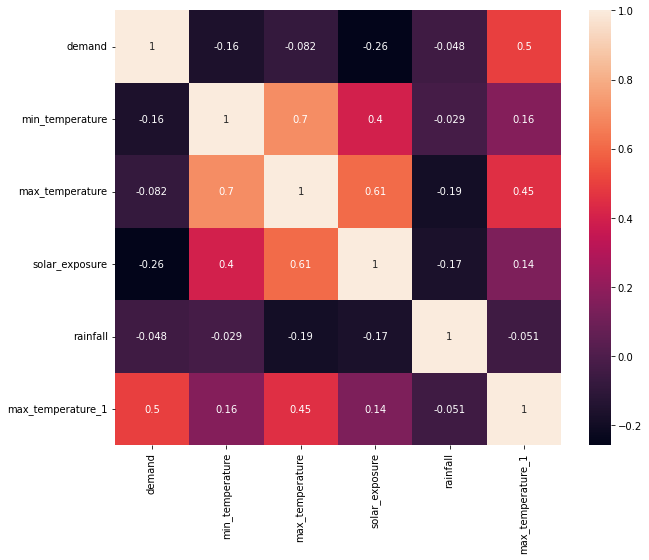

In [5]:
cor_Mat = df_final.corr()
# sns.set(rc = {'figure.figsize':(6,4)})
plt.figure(figsize=(10,8))
sns.heatmap(cor_Mat, annot=True)
plt.savefig('corr_heatmap.png', dpi=200)
plt.show()

## Model without extra-regressors

In [6]:
dmnd_uni = df_final['demand']
dmnd_train, dmnd_vali, dmnd_test = get_train_df(dmnd_uni, 'date', 'demand', '2018-06-06', vali_cut='2019-06-06')

Training sample size: 1252.
Validation sample size: 365.
Testing sample size: 489.


In [7]:
# Grid Search Parameters
# To reduce the space of parameters, we assume that all the seasonalities addtively impact the time series
y_mode_list = ['multiplicative','additive']
y_scale_list = [10]
cps_list = [0.001, 0.1]
hps_list = [0.001, 0.2, 1]
w_mode_list = ['multiplicative','additive']
w_scale_list = [10]
q_ind = [True]
q_mode_list = ['multiplicative','additive']
q_scale_list = [10]
m_ind = [True]
m_mode_list = ['multiplicative','additive']
m_scale_list = [10]

In [8]:
model_list, forecast_list, mae_list, cor_list, loss_list, paras = unimodel_grid_search(dmnd_train, dmnd_vali, 
                                                                                       y_mode_list, y_scale_list, 
                                                                                       cps_list, hps_list, 
                                                                                       w_mode_list, w_scale_list,
                                                                                       q_ind, q_mode_list, q_scale_list, 
                                                                                       m_ind, m_mode_list, m_scale_list, 
                                                                                       '2018-06-06', mae_w=0.7, cor_w=0.3)

18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing


Minimum Position: 59
Minimum Loss: -6.763480148361862
MAE: 6.511869823088121
Correlation: 0.7547859349682364
Best Parameters: 
y_mode:  y_scale:  cps:  hps:  w_mode:  w_scale:  q_ind:  q_mode:  q_scale:  m_ind:  m_mode:  m_scale: 
('additive', 10, 0.001, 0.2, 'multiplicative', 10, True, 'additive', 10, True, 'additive', 10)


In [9]:
univar_model, univar_future, univar_forecast = univar_model_train(dmnd_train, dmnd_vali, 
                                                                  y_mode='additive', y_scale=10, 
                                                                  cps=0.001, hps=0.2, 
                                                                  w_mode='multiplicative', w_scale=10, 
                                                                  f_period=len(dmnd_test) + len(dmnd_vali), 
                                                                  quater=True, q_mode='additive', q_scale=10, 
                                                                  month=True, m_mode='additive', m_scale=10)

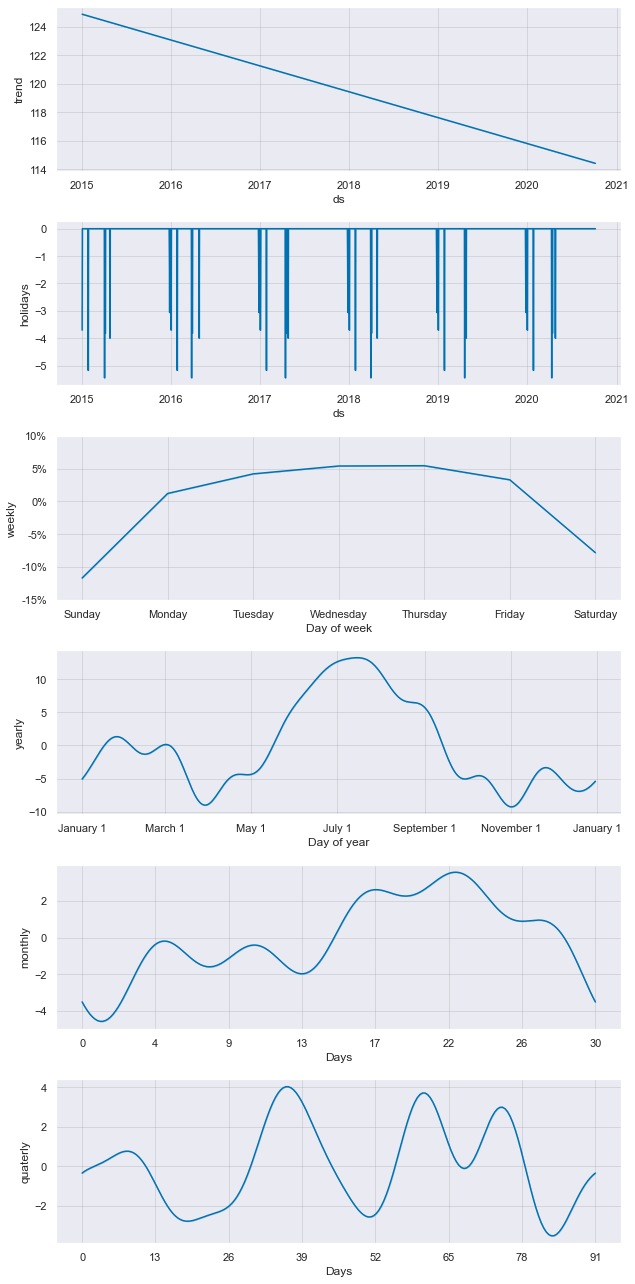

In [10]:
# plt.figure(dpi=200, figsize=(18,3))
figure_size=(18,12)
sns.set(rc = {'figure.figsize':figure_size})
univar_fig_1 = univar_model.plot_components(univar_forecast)
plt.savefig('unimodel_components.png', dpi=200)

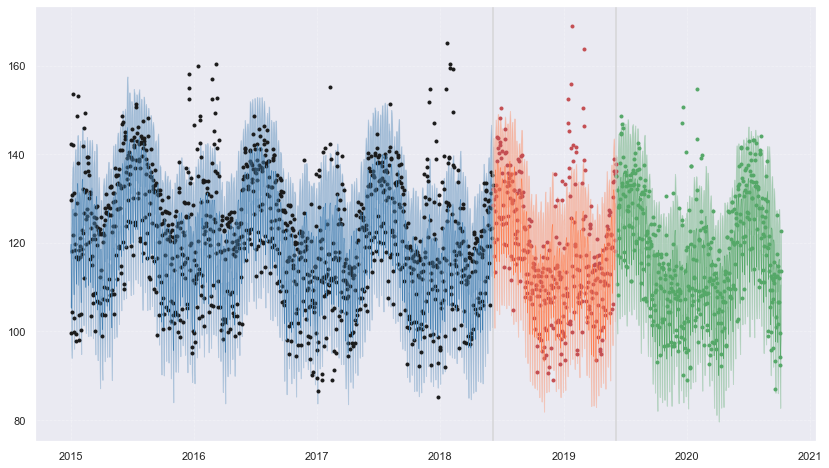

In [11]:
univar_verif = make_verif(univar_forecast, dmnd_uni, 'demand')
univar_verif_fig = plot_verif(univar_verif, '2018-06-06', test_cut='2019-06-06')
plt.savefig('unimodel_fits_predictions.png', dpi=200)

MAE on Testing Sample: 6.517496493435106
Correlation on Testing Sample: 0.765688996669


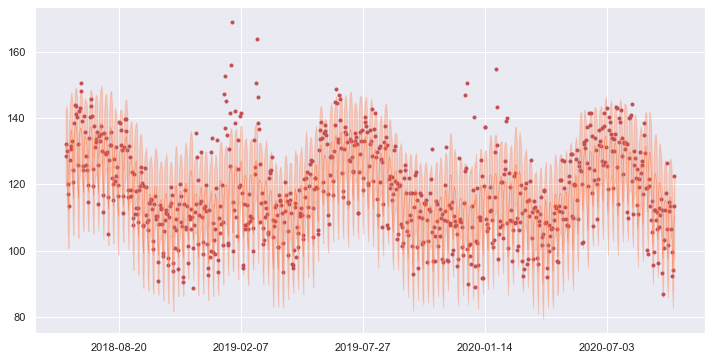

In [12]:
univar_test_fig = plot_test(univar_verif['2018-06-06':])
plt.savefig('unimodel_predictions.png', dpi=200)

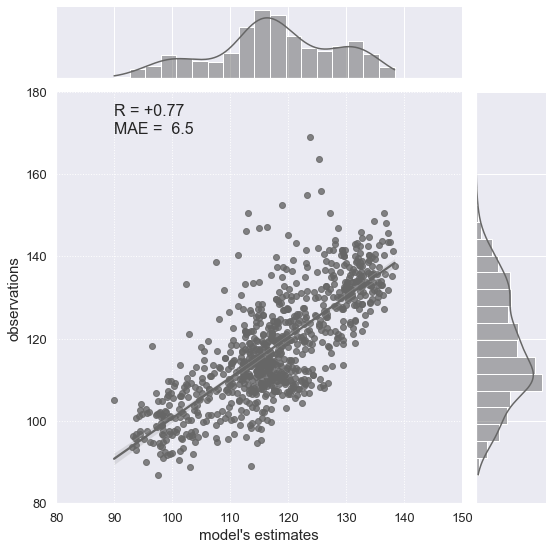

In [13]:
univar_joint_fig = plot_joint_plot(univar_verif['2018-06-06':], x_scale=[80,150], y_scale=[80,180], 
                                   legnd=[90,170], x='yhat', y='y', title=None, 
                                   fpath = '../Energy Demand Forecast', fname = 'unimodel_corr')

## Model with extra-regressor(Max Temperature)

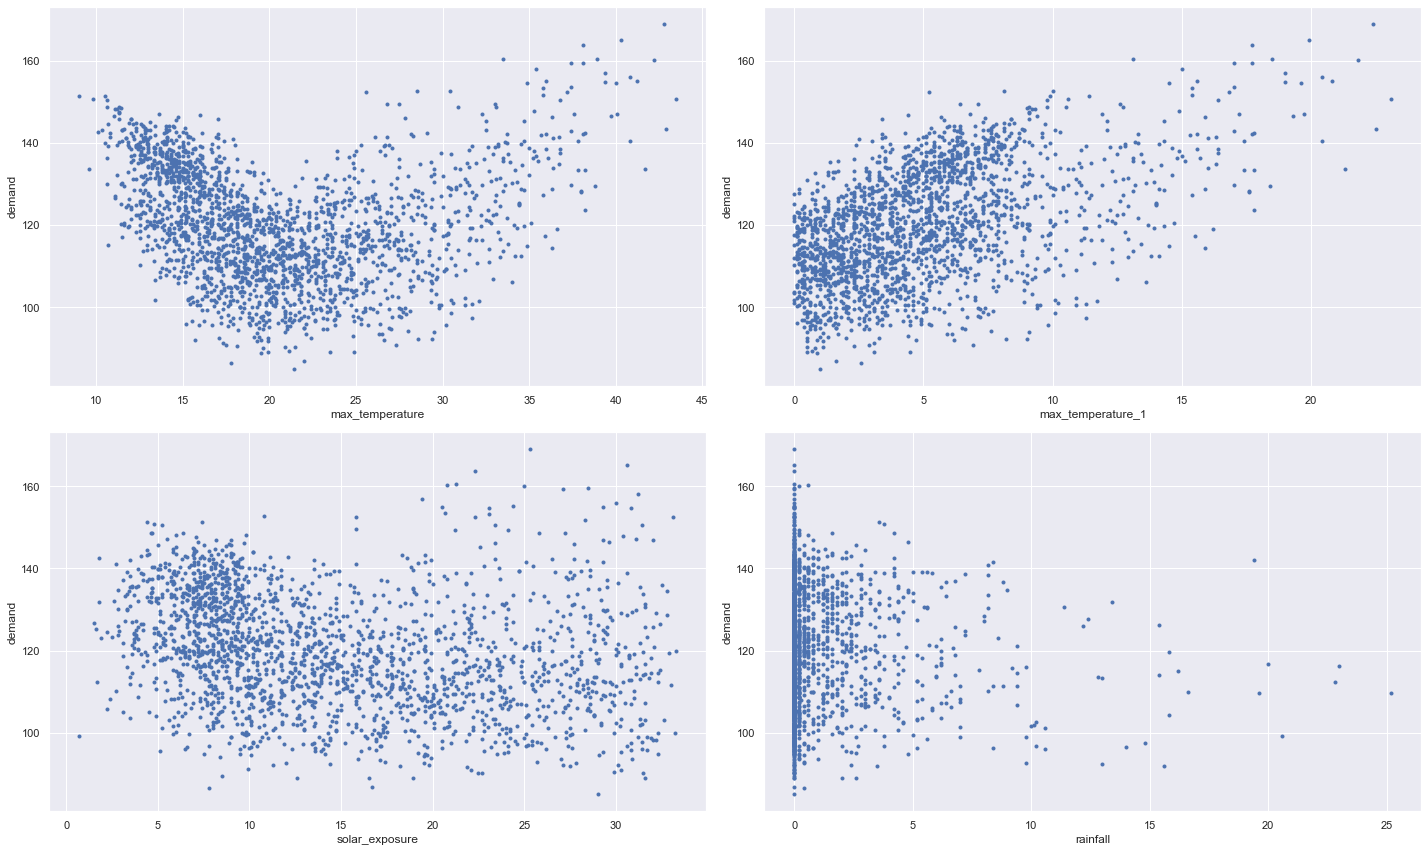

In [14]:
plt.figure(figsize=(20,12))
s_cols = ['max_temperature', 'max_temperature_1', 'solar_exposure', 'rainfall']
draw_scatter_plot(s_cols, 'demand', df_final, layout=(2,2))
plt.savefig('variable_scatters.png', dpi=200)

In [15]:
# Leverage temperature as extra regressor to improve the explainary of model
# temper = df_final['max_temperature']
temper = df_final['max_temperature_1']
extra_regs = [temper]

In [16]:
# Single extra regressor 
y_mode_list = ['additive']
y_scale_list = [0.001, 10]
cps_list = [0.001, 0.1]
hps_list = [0.001, 10]
w_mode_list = ['additive']
w_scale_list = [0.001, 10]
regnames_list = ['max_temperature_1']
regmodes_list = ['additive']
regstands_list = [True]
regprior_scales_list = [0.001, 10]
q_ind = [True]
q_mode_list = ['additive']
q_scale_list = [0.001, 10]
m_ind = [True]
m_mode_list = ['additive']
m_scale_list = [0.001, 10]

In [17]:
model_list, forecast_list, mae_list, cor_list, loss_list, paras  = multivar_grid_search(dmnd_train, dmnd_vali, extra_regs,
                                                                                         y_mode_list, y_scale_list, cps_list, hps_list, w_mode_list, w_scale_list,
                                                                                         regnames_list, regmodes_list, regstands_list, regprior_scales_list,
                                                                                         q_ind, q_mode_list, q_scale_list, m_ind, m_mode_list, m_scale_list,
                                                                                         '2018-06-06', mae_w=0.7, cor_w=0.3)

Minimum Position: 94
Minimum Loss: -9.575679069955685
MAE: 5.07614259912417
Correlation: 0.8752652592895068
Best Parameters: 
y_mode:  y_scale:  cps:  hps:  w_mode:  w_scale:  reg_name:  reg_mode:  reg_stand:  rps:  q_ind:  q_mode:  q_scale:  m_ind:  m_mode:  m_scale: 
('additive', 10, 0.001, 10, 'additive', 10, 'max_temperature_1', 'additive', True, 10, True, 'additive', 10, True, 'additive', 0.001)


In [18]:
multivar_model, multivar_futures, multivar_forecast = multivar_model_train(dmnd_train, dmnd_vali, extra_regs, 
                                                                            y_mode='additive',y_scale=10, cps=0.001, hps=10, w_mode='additive', w_scale=10,
                                                                            reg_names='max_temperature_1', reg_modes='additive', stands=True, reg_prior_scales=10, 
                                                                            lag=len(dmnd_test)+1, f_period=len(dmnd_test) + len(dmnd_vali), 
                                                                            quater=True, q_mode='additive', q_scale=10,
                                                                            month=True, m_mode='additive', m_scale=0.001)

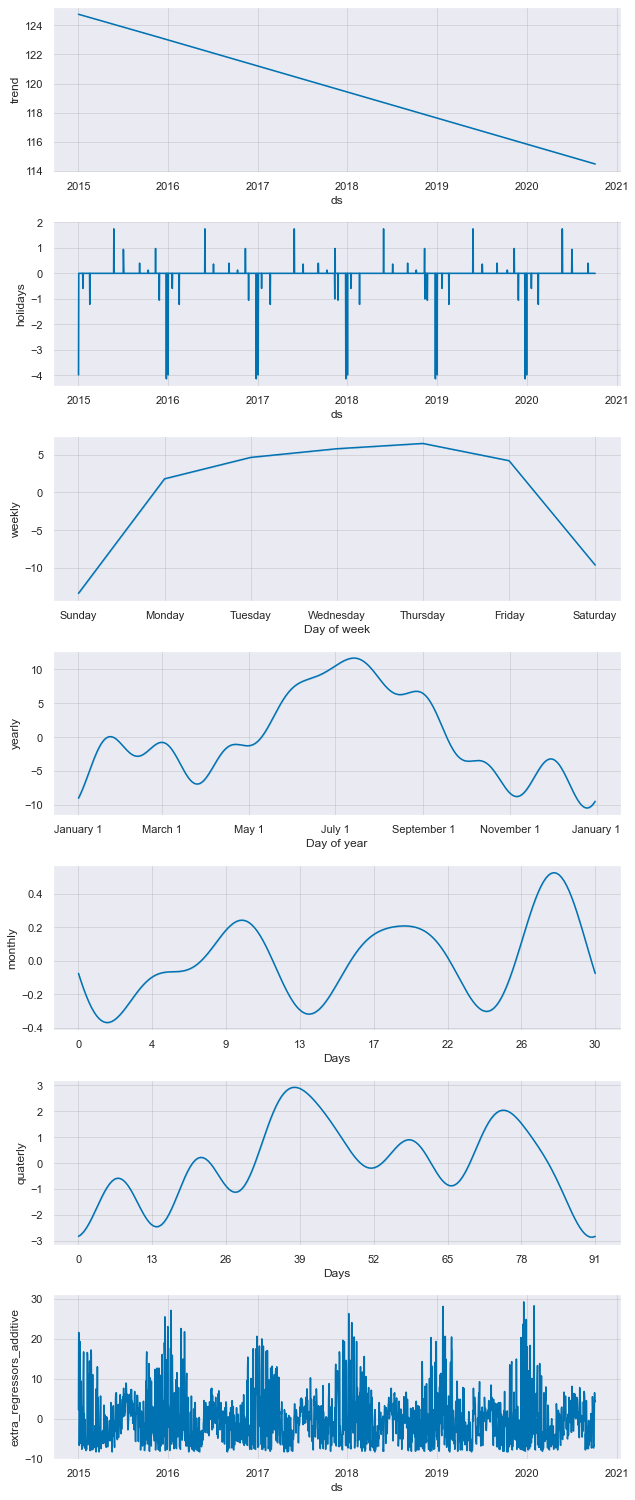

In [19]:
multivar_fig_1 = multivar_model.plot_components(multivar_forecast)
plt.savefig('multimodel_components.png', dpi=200)

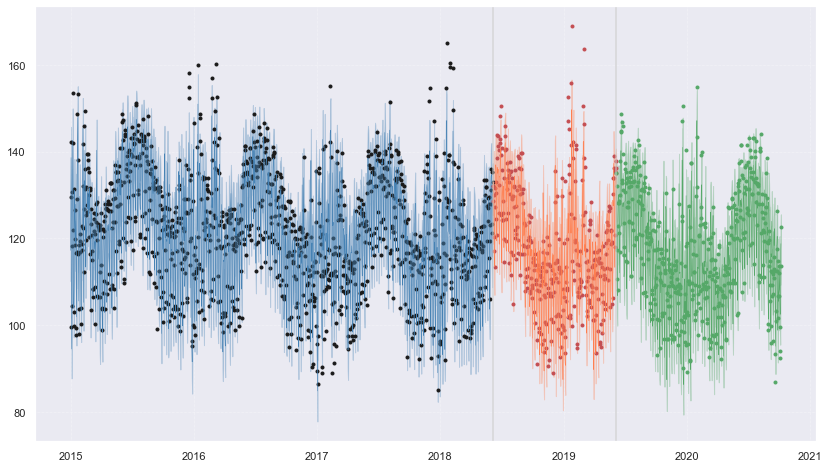

In [20]:
multivar_verif = make_verif(multivar_forecast, dmnd_uni, 'demand')
multivar_verif_fig = plot_verif(multivar_verif, '2018-06-06', test_cut='2019-06-06')
plt.savefig('multimodel_fits_predictions.png', dpi=200)

MAE on Testing Sample: 5.032216458146443
Correlation on Testing Sample: 0.881283660164876


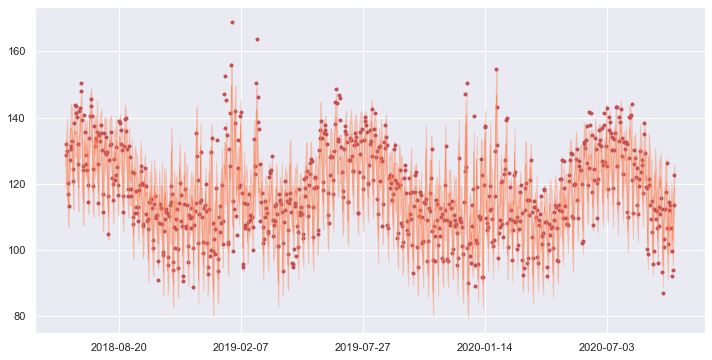

In [21]:
multivar_test_fig = plot_test(multivar_verif['2018-06-06':])
plt.savefig('multi_predictions.png', dpi=200)

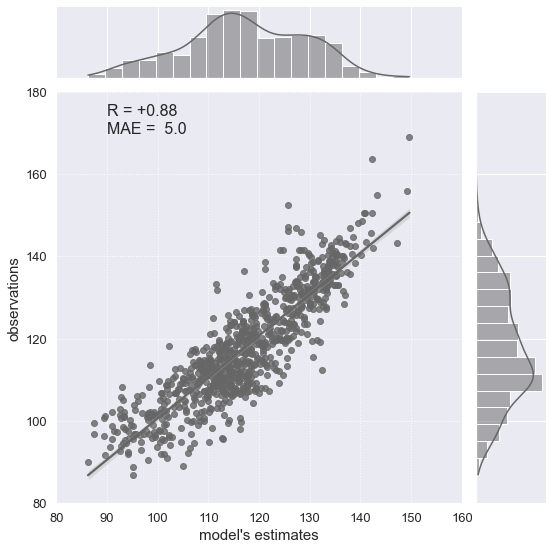

In [22]:
multivar_joint_fig = plot_joint_plot(multivar_verif['2018-06-06':], x_scale=[80,160], y_scale=[80,180], 
                                     legnd=[90,170], x='yhat', y='y', title=None, 
                                     fpath = '../Energy Demand Forecast', fname = 'multimodel_corr')